<a href="https://colab.research.google.com/github/VivekKejriwal/TheSchoolOfAI/blob/main/Assignment_5/Step4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install torch
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
#REQUIRED TRANSFORMS CREATED

train_transforms = transforms.Compose([
    transforms.RandomRotation((-10.0, 10.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((.1307,),(0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((.1307,),(0.3081,))
])

In [3]:
#LOADING REQUIRED MNIST DATA

train = datasets.MNIST('./data',download=True,train=True,transform= train_transforms)
test  = datasets.MNIST('./data',download=True,train=False,transform= test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
SEED = 1

#CUDA?
cuda = torch.cuda.is_available()
#print(cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size = 128, num_workers=4,pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

#train loader

train_loader = torch.utils.data.DataLoader(train,**dataloader_args)

#test loader

test_loader = torch.utils.data.DataLoader(test,**dataloader_args)

In [7]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()

    self.conv1 = nn.Sequential(
        nn.Conv2d(1,8,3,padding=1), #INPUT- 28X28X1 OUTPUT- 28X28X8 RF- 3
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=1), #INPUT- 28X28X8 OUTPUT- 28X28X8 RF- 5
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.MaxPool2d(2,2) #RF- 6
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(8,8,3,padding=0), #INPUT- 14X14X8 OUTPUT- 12X12X8 RF- 10
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=0), #INPUT- 12X12X8 OUTPUT- 10X10X8 RF-14
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,8,3,padding=0), #INPUT- 10X10X8 OUTPUT- 8X8X8 RF- 18
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.Dropout(0.01),
        nn.Conv2d(8,16,3,padding=0), #INPUT- 8X8X8 OUTPUT- 6X6X16 RF- 22
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.Dropout(0.01)
        
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(16,32,3), #INPUT- 6X6X16 OUTPUT- 4X4X32 RF-24
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Dropout(0.01),
        
        nn.AvgPool2d(4), #INPUT- 4X4X32 OUTPUT- 1X1X32 RF-40
        
        nn.Conv2d(32,10,1) #INPUT- 1X1X32 OUTPUT- 1X1X10
        
    )

  def forward(self,x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(-1,10)
    return F.log_softmax(x, dim=1)


In [8]:
!pip install torchsummary

from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)

model = Net().to(device)
summary(model, input_size = (1, 28, 28))


cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
              ReLU-3            [-1, 8, 28, 28]               0
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             584
       BatchNorm2d-6            [-1, 8, 28, 28]              16
              ReLU-7            [-1, 8, 28, 28]               0
           Dropout-8            [-1, 8, 28, 28]               0
         MaxPool2d-9            [-1, 8, 14, 14]               0
           Conv2d-10            [-1, 8, 12, 12]             584
      BatchNorm2d-11            [-1, 8, 12, 12]              16
             ReLU-12            [-1, 8, 12, 12]               0
          Dropout-13            [-1, 8, 12, 12]               0
           Conv2d-14            [-

In [9]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model,device,train_loader,optimizer,epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  
  for batch_id,(data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    y_pred = model(data)

    loss= F.nll_loss(y_pred,target)
    train_losses.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed+= len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_size={batch_id} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model,device,test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss = F.nll_loss(output, target, reduction='sum').item()
      pred = output.argmax(dim= 1,keepdim=True)
      correct+= pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Acccuracy= {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100.*correct/len(test_loader.dataset)))
  
  test_acc.append(100.*correct/len(test_loader.dataset))



In [10]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR


model = Net().to(device)
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)
EPOCHS = 20

for epoch in range(EPOCHS):
  print("EPOCH: ",epoch,"Last LR: ",scheduler.get_last_lr())
  train(model,device,train_loader,optimizer,epoch)
  scheduler.step()
  test (model,device,test_loader)
  

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH:  0 Last LR:  [0.01]


Loss=0.10405347496271133 Batch_size=468 Accuracy=87.56: 100%|██████████| 469/469 [00:16<00:00, 28.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9831/10000 (98.31%)

EPOCH:  1 Last LR:  [0.01]


Loss=0.19441509246826172 Batch_size=468 Accuracy=97.56: 100%|██████████| 469/469 [00:16<00:00, 28.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9861/10000 (98.61%)

EPOCH:  2 Last LR:  [0.01]


Loss=0.08435481041669846 Batch_size=468 Accuracy=98.00: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0004, Acccuracy= 9883/10000 (98.83%)

EPOCH:  3 Last LR:  [0.01]


Loss=0.03993356227874756 Batch_size=468 Accuracy=98.32: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9916/10000 (99.16%)

EPOCH:  4 Last LR:  [0.01]


Loss=0.02388674020767212 Batch_size=468 Accuracy=98.44: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0001, Acccuracy= 9896/10000 (98.96%)

EPOCH:  5 Last LR:  [0.01]


Loss=0.11840467900037766 Batch_size=468 Accuracy=98.60: 100%|██████████| 469/469 [00:16<00:00, 28.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9921/10000 (99.21%)

EPOCH:  6 Last LR:  [0.001]


Loss=0.01930028386414051 Batch_size=468 Accuracy=98.86: 100%|██████████| 469/469 [00:16<00:00, 28.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9940/10000 (99.40%)

EPOCH:  7 Last LR:  [0.001]


Loss=0.05699242278933525 Batch_size=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9951/10000 (99.51%)

EPOCH:  8 Last LR:  [0.001]


Loss=0.0025347541086375713 Batch_size=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9941/10000 (99.41%)

EPOCH:  9 Last LR:  [0.001]


Loss=0.0897146537899971 Batch_size=468 Accuracy=98.89: 100%|██████████| 469/469 [00:16<00:00, 28.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9944/10000 (99.44%)

EPOCH:  10 Last LR:  [0.001]


Loss=0.009367796592414379 Batch_size=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9945/10000 (99.45%)

EPOCH:  11 Last LR:  [0.001]


Loss=0.017689356580376625 Batch_size=468 Accuracy=98.94: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9943/10000 (99.43%)

EPOCH:  12 Last LR:  [0.0001]


Loss=0.020634207874536514 Batch_size=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9949/10000 (99.49%)

EPOCH:  13 Last LR:  [0.0001]


Loss=0.032936930656433105 Batch_size=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9948/10000 (99.48%)

EPOCH:  14 Last LR:  [0.0001]


Loss=0.06746562570333481 Batch_size=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9951/10000 (99.51%)

EPOCH:  15 Last LR:  [0.0001]


Loss=0.008842443116009235 Batch_size=468 Accuracy=99.00: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9946/10000 (99.46%)

EPOCH:  16 Last LR:  [0.0001]


Loss=0.015540041029453278 Batch_size=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9947/10000 (99.47%)

EPOCH:  17 Last LR:  [0.0001]


Loss=0.003437791019678116 Batch_size=468 Accuracy=99.01: 100%|██████████| 469/469 [00:16<00:00, 28.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9949/10000 (99.49%)

EPOCH:  18 Last LR:  [1e-05]


Loss=0.07325083762407303 Batch_size=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Acccuracy= 9948/10000 (99.48%)

EPOCH:  19 Last LR:  [1e-05]


Loss=0.0770743116736412 Batch_size=468 Accuracy=98.95: 100%|██████████| 469/469 [00:16<00:00, 28.95it/s]



Test set: Average loss: 0.0001, Acccuracy= 9947/10000 (99.47%)



Text(0.5, 1.0, 'Test Accuracy')

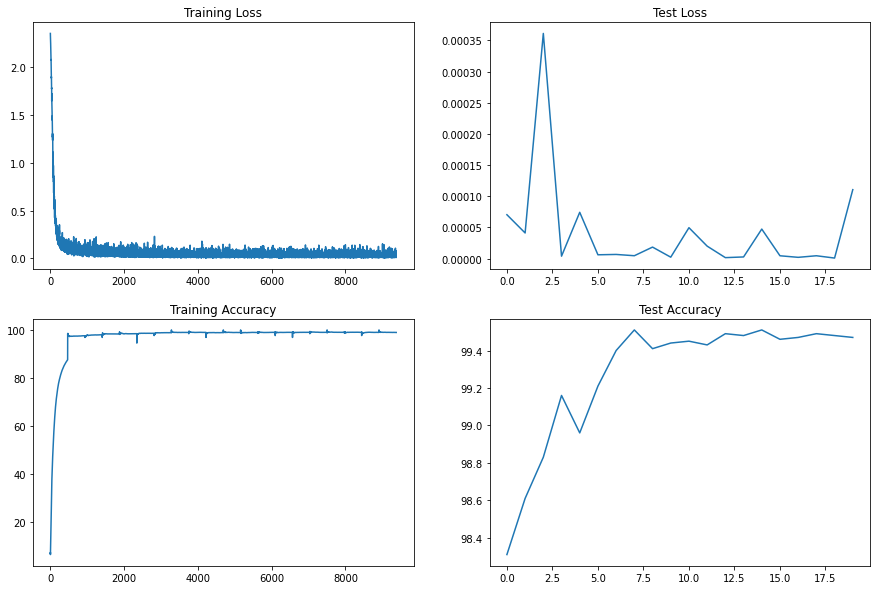

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2,2, figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Target:

        Add LR scheduler to further increase the learning speed

Results:

        Parameters: 8,730
        Best Train Accuracy: 99.01
        Best Test Accuracy: 99.51

Analysis:

        We have succesfully achieved the target of 99.4 consistently within
        15 epochs.


